# Análisis para tienda online
## Objetivo:
Análisis de hipótesis para el aumento de ingresos
### Objetivos específicos:
* Priorizar las hipótesis
* Analizar el test A/B
    * Ingreso acumudalo por grupo
    * Número de pedidos por grupo
    * Tamaño de pedido promedio por grupo y su diferencia relativa
    * Tasa de conversión para cada grupo
    * Identificar anomalías
    * Significancia estadística de la diferencia en la tasa de conversión y el ticket promedio para cada grupo


## Pasos a seguir
1. Priorizar las hipótesis
    * Aplicar framework ICE
    * Aplicar framework RICE

2. Análisis de test A/B
    * Limpieza de datos
    * Ingreso acumudalo por grupo
    * Número de pedidos por grupo
    * Tamaño de pedido promedio por grupo y su diferencia relativa
    * Tasa de conversión para cada grupo
    * Identificar anomalías
    * Significancia estadística de la diferencia en la tasa de conversión y el ticket promedio para cada grupo

3. Toma de decisión sobre la prueba

## Diccionario de datos

**Hypotheses** (hipótesis)
* ``Hypotheses``: breves descripciones de las hipótesis
* ``Reach``: alcance del usuario, en una escala del uno a diez
* ``Impact``: impacto en los usuarios, en una escala del uno al diez
* ``Confidence``: confianza en la hipótesis, en una escala del uno al diez
* ``Effort``: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba

**Orders** (pedidos realizados)
* ``transactionId``: identificador de pedido
* ``visitorId``: identificador del usuario que realizó el pedido
* ``date``: fecha del pedido
* ``revenue``: ingresos del pedido
* ``group``: el grupo del test A/B al que pertenece el usuario

**Visits** (registro de visitas)
* ``date``: la fecha
* ``group``: grupo de la prueba A/B
* ``visits``: el número de visitas en la fecha especificada en el grupo de pruebas A/B especificado

In [1]:
# importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

# Priorizar hipótesis

In [2]:
# importar hipótesis
hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')

# información general de 'hypotheses'
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [3]:
# nombres de columnas
hypotheses.columns = hypotheses.columns.str.lower()

In [4]:
# mostrar hipótesis
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [5]:
# elaborar frameworks
# calcular 'ICE'
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

# calcular 'RICE'
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

In [6]:
# prioridad de las hipótesis
print('Framework ICE', '\n', hypotheses[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))
print()
print('Framework RICE', '\n', hypotheses[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

Framework ICE 
                                           hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000

Framework RICE 
                                           hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that

### Comentario
Hay una diferencia en la priorización de las hipótesis dependiendo del framework empleado, esto se debe al parámetro 'reach' que emplea el 'RICE'. Sugiero priorizar las hipótesis tomando en cuenta ambos métodos para considerar tanto el impacto como el alcance.

Hipótesis recomendadas por orden de prioridad:
1) hipótesis 8: Add a subscription form to all the main pages. This will help you compile a mailing list
2) hipótesis 1: Add two new channels for attracting traffic. This will bring 30% more users
3) hipótesis 3: Add product recommendation blocks to the store's site. This will increase conversion and average purchase size

# Análisis de test A/B

In [7]:
# importar datasets
orders = pd.read_csv('orders_us.csv')
visits = pd.read_csv('visits_us.csv')

## visualización general de los datos

In [8]:
# información general de 'orders'
orders.info()
print('\n', 'Valores duplicados:', orders.duplicated().sum())
print('\n', orders.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB

 Valores duplicados: 0

      transactionId   visitorId        date  revenue group
489     3245585636   938079215  2019-08-26    175.3     B
484     2631228632  1772171838  2019-08-06    100.3     A
170      617930325  2785040378  2019-08-01     55.8     A
41      2594268419   237748145  2019-08-15     20.8     A
488     2882003943  3212572194  2019-08-19     30.4     A


In [9]:
# información general de 'visits'
visits.info()
print('\n', 'Valores duplicados:', visits.duplicated().sum())
print('\n', visits.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

 Valores duplicados: 0

           date group  visits
28  2019-08-29     A     577
5   2019-08-06     A     667
60  2019-08-30     B     490
11  2019-08-12     A     595
53  2019-08-23     B     546


### Comentario
Los datasets no presentan valores nulos ni duplicados. Hay que darle formato al nombre de las columnas del df 'orders' y convertir la columna 'date' de ambos df's al formato adecuado.

## Limpieza de datos

In [10]:
# formatear nombres de columnas de 'orders'
orders.columns = orders.columns.str.lower()
orders.rename(columns={'transactionid':'transaction_id', 'visitorid':'visitor_id'}, inplace=True)

# conversión de columnas 'date'
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

## Análisis de resultados

In [11]:
print('Inicio de la prueba:', orders['date'].min())
print('Fecha corte:', orders['date'].max())

Inicio de la prueba: 2019-08-01 00:00:00
Fecha corte: 2019-08-31 00:00:00


In [12]:
# lista de usuarios
users_group_a = orders[orders['group'] == 'A']['visitor_id'].unique()
users_group_b = orders[orders['group'] == 'B']['visitor_id'].unique()
# tamaño de grupos
print('Tamaño grupo A:', len(users_group_a))
print('Tamaño grupo B:', len(users_group_b))

Tamaño grupo A: 503
Tamaño grupo B: 586


In [13]:
# usuarios en común grupo A y B
common_users = np.intersect1d(users_group_a, users_group_b)
print('Usuarios en ambos grupos:', len(common_users))

Usuarios en ambos grupos: 58


In [14]:
# filtrar 'orders' sin usuarios duplicados
filtered_orders = orders[np.logical_not(orders['visitor_id'].isin(common_users))]

# usuarios por grupo
# lista de usuarios
users_group_a = filtered_orders[filtered_orders['group'] == 'A']['visitor_id'].unique()
users_group_b = filtered_orders[filtered_orders['group'] == 'B']['visitor_id'].unique()
# tamaño de grupos
print('Tamaño grupo A:', len(users_group_a))
print('Tamaño grupo B:', len(users_group_b))

Tamaño grupo A: 445
Tamaño grupo B: 528


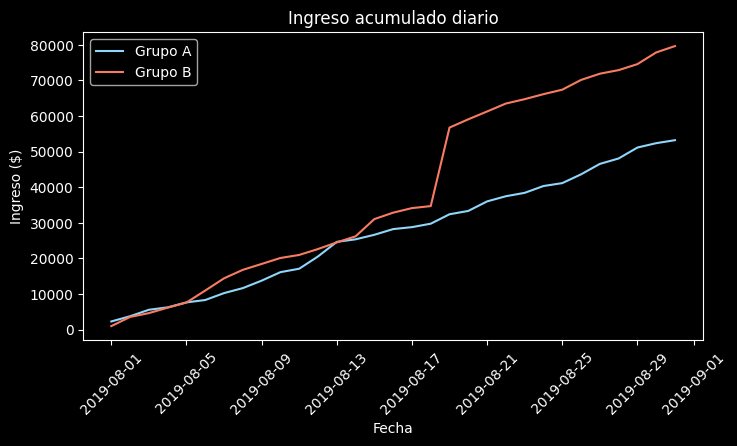

In [15]:
# ingreso acumulado diario por grupo
# dataframe ingresos acumulados diarios
daily_cumulative_revenue = filtered_orders.groupby(['group', 'date'], as_index=False)['revenue'].sum()

# ordenar cronológicamente
daily_cumulative_revenue = daily_cumulative_revenue.sort_values(['group', 'date'])

# calcular ingreso acumulado diario
daily_cumulative_revenue['cumulative_revenue'] = daily_cumulative_revenue.groupby('group')['revenue'].cumsum()

# gráfico de líneas: ingreso acumulado diario
plt.style.use('dark_background')
plt.figure(figsize=(8,4))
colors = {'A': '#8FD6FA', 'B': '#F87C63'}
for grp in ['A', 'B']:
    grp_data = daily_cumulative_revenue[daily_cumulative_revenue['group'] == grp]
    plt.plot(grp_data['date'], grp_data['cumulative_revenue'], label=f'Grupo {grp}', color=colors[grp])
plt.title('Ingreso acumulado diario')
plt.xlabel('Fecha')
plt.ylabel('Ingreso ($)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

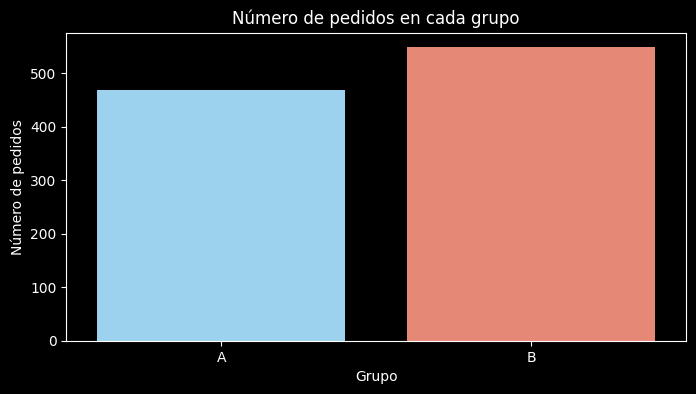

In [16]:
# número de pedidos por grupo
orders_per_group = filtered_orders.groupby('group', as_index=False)['transaction_id'].nunique()
orders_per_group.rename(columns={'transaction_id':'num_orders'}, inplace=True)

# gráfico de barras: número de pedidos por grupo
plt.figure(figsize=(8,4))
sns.barplot(orders_per_group,
            x='group',
            y='num_orders',
            hue='group',
            palette={'A': '#8FD6FA', 'B': '#F87C63'})
plt.title('Número de pedidos en cada grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de pedidos')
plt.show()

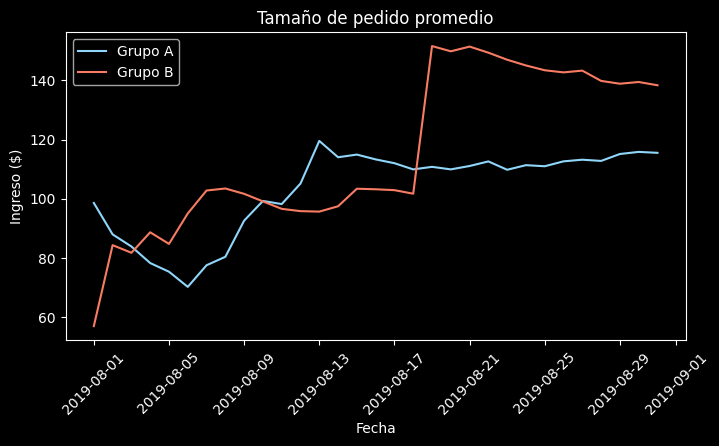

In [17]:
# tamaño de pedido promedio
# dataframe tamaño de pedido promedio diario
daily_cumulative_avg = filtered_orders.groupby(['group', 'date'], as_index=False)['revenue'].mean()

# ordenar cronológicamente
daily_cumulative_avg = daily_cumulative_avg.sort_values(by=['group', 'date'])

# calcular 'AOV'
daily_cumulative_avg['AOV'] = daily_cumulative_avg.groupby('group')['revenue'].transform(lambda x: x.expanding().mean())

# gráfico de líneas: tamaño de pedido promedio acumulado
plt.figure(figsize=(8,4))
colors = {'A': '#8FD6FA', 'B': '#F87C63'}
for grp in ['A', 'B']:
    grp_data = daily_cumulative_avg[daily_cumulative_avg['group'] == grp]
    plt.plot(grp_data['date'], grp_data['AOV'], label=f'Grupo {grp}', color=colors[grp])
plt.title('Tamaño de pedido promedio')
plt.xlabel('Fecha')
plt.ylabel('Ingreso ($)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

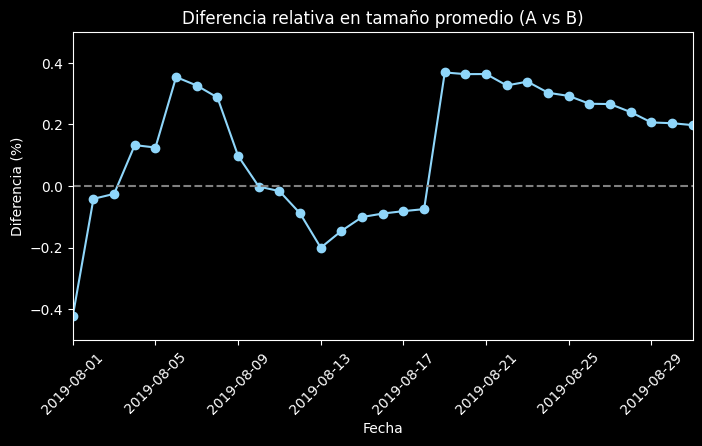

In [18]:
# diferencia relativa en el tamaño de pedido promedio
# tabla dinámica del 'AOV' por grupo
diff_relative_aov = daily_cumulative_avg.pivot(
    index='date',
    columns='group',
    values='AOV',
).reset_index()

# calcular la diferencia relativa
diff_relative_aov ['diff_relative'] = (diff_relative_aov['B'] - diff_relative_aov['A']) / diff_relative_aov['A']

# gráfico de líneas: diferencia relativa en tamaño promedio
plt.figure(figsize=(8,4))
plt.plot(diff_relative_aov['date'], diff_relative_aov['diff_relative'], marker='o', color='#8FD6FA')
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-08-31'), -0.5, 0.5])
plt.title('Diferencia relativa en tamaño promedio (A vs B)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia (%)')
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.show()

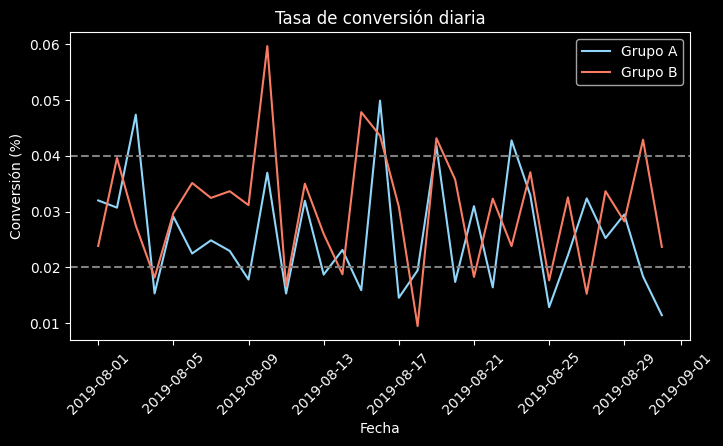

In [19]:
# tasa de conversión 
# dataframe número de órdenes por día
num_orders = (
    filtered_orders.groupby(['group', 'date'], as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
)

# dataframe une órdenes por día y visitas por día
orders_visits_per_day = pd.merge(num_orders, visits, on=['group', 'date'])
orders_visits_per_day.rename(columns={'transaction_id':'num_orders'}, inplace=True)

# calcular tasa de conversión
orders_visits_per_day['conversion'] = orders_visits_per_day['num_orders'] / orders_visits_per_day['visits']

# ordernar cronológicamente
orders_visits_per_day = orders_visits_per_day.sort_values(by=['group', 'date'])

# gráfico de líneas: tasa de conversión diaria por grupo
plt.figure(figsize=(8,4))
colors = {'A': '#8FD6FA', 'B': '#F87C63'}
for grp in ['A', 'B']:
    grp_data = orders_visits_per_day[orders_visits_per_day['group'] == grp]
    plt.plot(grp_data['date'], grp_data['conversion'], label=f'Grupo {grp}', color=colors[grp])
plt.title('Tasa de conversión diaria')
plt.xlabel('Fecha')
plt.ylabel('Conversión (%)')
plt.axhline(0.04, color='grey', linestyle='--')
plt.axhline(0.02, color='grey', linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.show()